# Topic: Load  a U-Net model pre-trained for abnormality segmentation on a dataset of brain MRI volumes

In [1]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

/home/dxj/.local/lib/python3.8/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /home/dxj/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /home/dxj/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [2]:
# Download an example image
import urllib
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
def load_and_display_image(filepath, title="Image"):        
    try:
        # Load the image
        img = Image.open(filepath).convert("RGB")
        
        # Convert to a PyTorch tensor
        transform = transforms.ToTensor()
        image_tensor = transform(img)  # Shape: (C, H, W)
        
        # Get resolution
        resolution = f"{img.width}x{img.height}"  # Width x Height

        # Print file path and resolution
        print(f"Filepath: {filepath}")
        print(f"Resolution: {resolution}")
        
        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_tensor.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.title(f"{title}\nResolution: {resolution}")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error loading image: {e}")

Filepath: TCGA_CS_4944.png
Resolution: 256x256


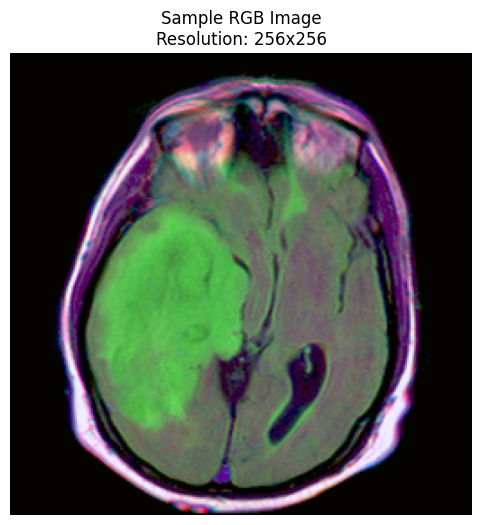

In [5]:
load_and_display_image(filename, title="Sample RGB Image")

In [6]:
import numpy as np
from PIL import Image
from torchvision import transforms

input_image = Image.open(filename)
# original shape is [C,H,W]]
# m: mean, s: standard deviation. calculate them through the spatial dimensions(height and width))
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
# here the When np.mean() or np.std() is called with axis=(0, 1), it computes the statistics across the height (H) and width (W) of the image, while keeping the computation separate for each color channel (C)

print(m,s)

[59.65196228 66.12484741 57.84906006] [59.07813102 68.73045249 58.8932161 ]


In [3]:
# Converts the image to a pytorch tensor with pixel value scaled between 0 and 1.
# then normalise the tensor using m and s.
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) #to add a batch dimension, now the shape will be [1,c,h,w]

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

print(torch.round(output[0]))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


In [15]:
print(output.shape)

torch.Size([3, 128, 128])


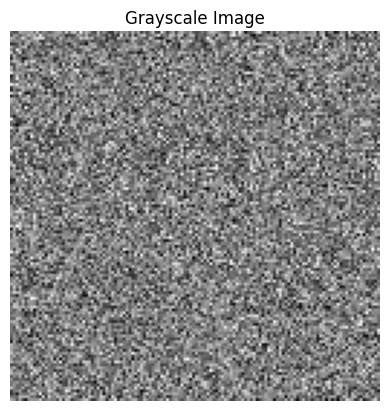

In [16]:
tensor =output
# Step 1: Check dimensions and reduce to 2D
if tensor.ndim == 3:  # If shape is [C, H, W]
    tensor = tensor.mean(dim=0)  # Convert to grayscale by averaging channels

elif tensor.ndim == 4:  # If shape is [N, C, H, W]
    tensor = tensor[0].mean(dim=0)  # Take the first image and average channels

# Step 2: Normalize to [0, 255]
tensor_normalized = (tensor - tensor.min()) / (tensor.max() - tensor.min())
tensor_rescaled = (tensor_normalized * 255).byte()

# Step 3: Convert to NumPy
image_np = tensor_rescaled.numpy()

# Step 4: Display the image
image = Image.fromarray(image_np, mode='L')  # 'L' for grayscale
image.show()

# Optional: Use Matplotlib for inline display
plt.imshow(image_np, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

- Input images for pre-trained model should have 3 channels and be resized to 256x256 pixels and z-score normalized per volume.
- 

In [37]:
class CNNBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.seq_block(x)
        return x

In [38]:
class CNNBlocks(nn.Module):
    """
    Parameters:
    n_conv (int): creates a block of n_conv convolutions
    in_channels (int): number of in_channels of the first block's convolution
    out_channels (int): number of out_channels of the first block's convolution
    expand (bool) : if True after the first convolution of a blocl the number of channels doubles
    """
    def __init__(self,
                 n_conv,
                 in_channels,
                 out_channels,
                 padding):
        super(CNNBlocks, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(n_conv):

            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            # after each convolution we set (next) in_channel to (previous) out_channels
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [26]:
class Encoder(nn.Module):
    """
    Parameters:
    in_channels (int): number of in_channels of the first CNNBlocks
    out_channels (int): number of out_channels of the first CNNBlocks
    padding (int): padding applied in each convolution
    downhill (int): number times a CNNBlocks + MaxPool2D it's applied.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 padding,
                 downhill=4):
        super(Encoder, self).__init__()
        self.enc_layers = nn.ModuleList()

        for _ in range(downhill):
            self.enc_layers += [
                    CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                    nn.MaxPool2d(2, 2)
                ]

            in_channels = out_channels
            out_channels *= 2
        # doubling the dept of the last CNN block
        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels,
                                         out_channels=out_channels, padding=padding))

    def forward(self, x):
        route_connection = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                route_connection.append(x)
            else:
                x = layer(x)
        return x, route_connection

In [39]:
class Decoder(nn.Module):
    """
    Parameters:
    in_channels (int): number of in_channels of the first ConvTranspose2d
    out_channels (int): number of out_channels of the first ConvTranspose2d
    padding (int): padding applied in each convolution
    uphill (int): number times a ConvTranspose2d + CNNBlocks it's applied.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 exit_channels,
                 padding,
                 uphill=4):
        super(Decoder, self).__init__()
        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(uphill):

            self.layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(n_conv=2, in_channels=in_channels,
                          out_channels=out_channels, padding=padding),
            ]
            in_channels //= 2
            out_channels //= 2

        # cannot be a CNNBlock because it has ReLU incorpored
        # cannot append nn.Sigmoid here because you should be later using
        # BCELoss () which will trigger the amp error "are unsafe to autocast".
        self.layers.append(
            nn.Conv2d(in_channels, exit_channels, kernel_size=1, padding=padding),
        )
        

    def forward(self, x, routes_connection):
        # pop the last element of the list since
        # it's not used for concatenation
        routes_connection.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                # center_cropping the route tensor to make width and height match
                routes_connection[-1] = center_crop(routes_connection[-1], x.shape[2])
                # concatenating tensors channel-wise
                x = torch.cat([x, routes_connection.pop(-1)], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

In [40]:
class UNET(nn.Module):
    def __init__(self,
                 in_channels,
                 first_out_channels,
                 exit_channels,
                 downhill,
                 padding=0
                 ):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, downhill=downhill)
        self.decoder = Decoder(first_out_channels*(2**downhill), first_out_channels*(2**(downhill-1)),
                               exit_channels, padding=padding, uphill=downhill)

    def forward(self, x):
        enc_out, routes = self.encoder(x)
        out = self.decoder(enc_out, routes)
        return out

In [41]:
model = UNET(3, 64, 1, padding=0, downhill=4)
print(model)

UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2-3): 2 x CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(64, 128, kernel_size=(3, 3), 

In [43]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(3, 64, 1, padding=0, downhill=4).to(device)

print(summary(model, (3, 256, 256)))

RuntimeError: Given groups=1, weight of size [128, 64, 3, 3], expected input[2, 128, 122, 122] to have 64 channels, but got 128 channels instead

In [44]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/dxj/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [46]:
model.to(device)
print(summary(model, (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,